## R-peak Detection

This example contains the code for training a deep learning model for the R-peak detection task. As the task is not complex, it can be trained with high accuracy on a small amount of data.
In this example, the electrocardiogram signals are segmented into ten seconds ecxerpts. Each excerpt corresponds to an annotation list of length 600 containing zeros and ones. A subsegment with an R-peak corresponds to one in the annotation list.

This example is availble on [GitHub](https://github.com/devnums/pyheartlib/blob/main/examples/).

<a target="_blank" href="https://colab.research.google.com/github/devnums/pyheartlib/blob/main/examples/model/rpeak_detection.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Pyheartlib

In [32]:
try:
    import pyheartlib
    print('pyheartlib is already installed')
except ModuleNotFoundError:
    print('Installing pyheartlib...')
    !pip install pyheartlib

pyheartlib is already installed


### Download raw data

In [33]:
# download the raw data and store them in the data directory
from pathlib import Path
if not Path('data').is_dir():
  print('downloading raw data...')
  import io, zipfile
  from urllib.request import urlopen
  url='https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip'
  with urlopen(url) as rs:
      zipf = zipfile.ZipFile(io.BytesIO(rs.read()))
      zipf.extractall('data/')

  # create the config file, for this example just download it from the original repository
  with urlopen("https://raw.githubusercontent.com/devnums/pyheartlib/main/src/pyheartlib/config.yaml") as file:
      content = file.read().decode()
  with open("data/config.yaml", 'w') as file:
      file.write(content)

### Create dataset

In [3]:
import os

from pyheartlib.data_rpeak import ECGSequence, RpeakData
from pyheartlib.io import load_data

data_dir = "data"
# create train, validation, and test sets
rpeak_data = RpeakData(base_path=data_dir, remove_bl=False, lowpass=False, progress_bar=False)

train_set = rpeak_data.config["DS1"][:18]
val_set = rpeak_data.config["DS1"][18:]
test_set = rpeak_data.config["DS2"]

annotated_records, samples_info = rpeak_data.save_samples(
    rec_list=train_set, file_name="train.rpeak", win_size=10 * 360, stride=1440
)
annotated_records, samples_info = rpeak_data.save_samples(
    rec_list=val_set, file_name="val.rpeak", win_size=10 * 360, stride=1440
)
annotated_records, samples_info = rpeak_data.save_samples(
    rec_list=test_set, file_name="test.rpeak", win_size=10 * 360, stride=1440
)

# for verfication
train_data = os.path.join(data_dir, "train.rpeak")
annotated_records, samples_info = load_data(train_data)
print("number of generated sampels:", str(len(samples_info)))

trainseq = ECGSequence(
    annotated_records,
    samples_info,
    binary=True,
    batch_size=1,
    raw=True,
    interval=6,
)

i = 0
label = trainseq[i][1]  # excerpt label
seq = trainseq[i][0]  # excerpt values

print("len label:", len(label[0]), "len seq:", len(seq[0]))


100%|██████████| 18/18 [00:00<00:00, 18.09it/s]


File saved at: data/train.rpeak


100%|██████████| 4/4 [00:00<00:00, 12.80it/s]


File saved at: data/val.rpeak


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


File saved at: data/test.rpeak
File loaded from: data/train.rpeak
number of generated sampels: 8082
len label: 600 len seq: 3600


### Model architecture

In [4]:
# model architecture
import tensorflow as tf
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    BatchNormalization,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPool1D,
)

def print_layer(layer):
    """Prints layer output dim and its name or class name"""
    l_out_shape = tf.keras.backend.shape(layer)._inferred_value
    l_name = layer.name
    print(
        "\nLayer: {} -->  Output shape: {}".format(
            str(l_name).upper(), str(l_out_shape)
        )
    )

def reg():
    return tf.keras.regularizers.l2(l=0.01)

def conv1d_block(
    inp,
    name=None,
    filters=64,
    kernel_size=64,
    bn=True,
    drate=0.30,
    pool_size=0,
    flatten=True,
    regularizer=None,
):
    output = Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        strides=1,
        padding="same",
        activation=None,
        kernel_regularizer=regularizer,
    )(inp)
    if bn:
        output = BatchNormalization(axis=-1)(output)
    output = Activation("relu")(output)
    if drate > 0:
        output = Dropout(drate)(output)
    if pool_size > 0:
        output = MaxPool1D(pool_size=pool_size)(output)
    if flatten:
        output = Flatten()(output)

    print_layer(output)
    return output

def model_arch(params_model):
    x_input_dim = int(params_model["x_input_dim"])
    num_classes = int(params_model["num_classes"])
    # out_seq_len = int(params_model["out_seq_len"])

    input1_layer = Input(shape=(x_input_dim), name="x_input_dim")
    # input1_layer = Input(shape=(150,14), name='x_input_dim')
    print_layer(input1_layer)

    # input: (None,seq_len)  --> (None,seq_len,1)
    out = tf.expand_dims(input1_layer, axis=-1)
    print_layer(out)

    out = BatchNormalization()(out)
    print_layer(out)
    out = conv1d_block(
        out,
        name="block1",
        filters=16,
        kernel_size=6,
        bn=True,
        drate=0.2,
        pool_size=6,
        flatten=False,
    )
    out = Activation("relu")(out)
    out = Bidirectional(LSTM(32, return_sequences=True))(out)
    out = Dropout(0.2)(out)
    print_layer(out)
    out = Bidirectional(LSTM(32, return_sequences=True))(out)
    out = Dropout(0.2)(out)
    print_layer(out)
    out = Dense(64, activation="relu")(out)
    out = Dropout(0.2)(out)
    out = Dense(num_classes, activation="softmax")(out)
    print_layer(out)
    return tf.keras.Model(inputs=input1_layer, outputs=out, name="model_rpeak")


### Train model

In [5]:
import os

from pyheartlib.extra.utils import reset_seed
from pyheartlib.io import load_data

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf  # noqa: E402

data_dir = "data"
train_data = os.path.join(data_dir, "train.rpeak")
val_data = os.path.join(data_dir, "val.rpeak")
mdl_checkpoint = os.path.join(os.getcwd(), "checkpoint/keras.exp")
interval_value = 6

reset_seed()

# load train data
annotated_records, samples_info = load_data(train_data)
print("Train data loaded, number of sampels:", str(len(samples_info)))

labels = []
for sample in samples_info:
    labels.append(sample[3])
print(len(labels))

params_model = {
    "x_input_dim": samples_info[0][2] - samples_info[0][1],  # win size
    "out_seq_len": len(labels[0]),
    "num_classes": 2,
    "regularizer": None,
}
print(params_model)
params_train = {"batch_size": 32, "epochs": 3}

mymodel = model_arch(params_model)
opt = tf.keras.optimizers.Adam(
    learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adam"
)
mymodel.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    loss_weights=None,
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=8, verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.9,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0001,
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    mdl_checkpoint,
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
)
import time  # noqa: E402

batch_sleep = tf.keras.callbacks.LambdaCallback(
    on_batch_end=lambda batch, logs: time.sleep(0.0001)
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]
# callbacks = [batch_sleep]

from pyheartlib.data_rpeak import ECGSequence  # noqa: E402

trainseq = ECGSequence(
    annotated_records,
    samples_info,
    binary=True,
    batch_size=params_train["batch_size"],
    raw=True,
    interval=interval_value,
)

print("trainseq.shape: ", str(trainseq[0][0].shape))
print(trainseq[0][0].shape, trainseq[0][1].shape)

# load validation data
annotated_records_val, samples_info_val = load_data(val_data)

validationseq = ECGSequence(
    annotated_records_val,
    samples_info_val,
    binary=True,
    batch_size=params_train["batch_size"],
    raw=True,
    interval=interval_value,
)

# train model
model_history = mymodel.fit(
    x=trainseq,
    validation_data=validationseq,
    use_multiprocessing=True,
    # workers=2,
    epochs=params_train["epochs"],
    verbose=1,
    callbacks=callbacks,
)


File loaded from: data/train.rpeak
Train data loaded, number of sampels: 8082
8082
{'x_input_dim': 3600, 'out_seq_len': 100, 'num_classes': 2, 'regularizer': None}

Layer: X_INPUT_DIM -->  Output shape: [None, 3600]

Layer: TF.EXPAND_DIMS/EXPANDDIMS:0 -->  Output shape: [None, 3600, 1]

Layer: BATCH_NORMALIZATION/BATCHNORM/ADD_1:0 -->  Output shape: [None, 3600, 1]

Layer: MAX_POOLING1D/SQUEEZE:0 -->  Output shape: [None, 600, 16]

Layer: DROPOUT_1/IDENTITY:0 -->  Output shape: [None, 600, 64]

Layer: DROPOUT_2/IDENTITY:0 -->  Output shape: [None, 600, 64]

Layer: DENSE_1/SOFTMAX:0 -->  Output shape: [None, 600, 2]
trainseq.shape:  (32, 3600)
(32, 3600) (32, 600)
File loaded from: data/val.rpeak
Epoch 1/3
253/253 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9899
Epoch 1: val_loss improved from inf to 0.01342, saving model to /content/checkpoint/keras.exp
253/253 [==============================] - 88s 243ms/step - loss: 0.0326 - accuracy: 0.9899 - val_loss: 0.

### Inference

In [9]:
import os
import textwrap

import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

from pyheartlib.io import load_data

data_dir = "data"
test_data = os.path.join(data_dir, "test.rpeak")
mdl_checkpoint = os.path.join(os.getcwd(), "checkpoint/keras.exp")
interval_value = 6

# load trained model
loaded_model = tf.keras.models.load_model(mdl_checkpoint)

# load test data
annotated_records_test, samples_info_test = load_data(test_data)
print(len(samples_info_test))
from pyheartlib.data_rpeak import ECGSequence  # noqa: E402

batch_size = 128
testseq = ECGSequence(
    annotated_records_test,
    samples_info_test,
    binary=True,
    batch_size=batch_size,
    raw=True,
    interval=interval_value,
    shuffle=False,
)
labels_true = []
labels_pred = []
for i in tqdm(range(round(len(samples_info_test) / batch_size))):
    samples = testseq[i]
    labels_true.extend(samples[1])
    probs = loaded_model.predict(samples[0], verbose=0)  # predict
    labels_pred.extend(list(np.argmax(probs, axis=-1)))
labels_true = np.array(labels_true)
labels_pred = np.array(labels_pred)
assert labels_true.shape == labels_pred.shape

# print classification_report and confusion_matrix
true = labels_true.flatten()
pred = labels_pred.flatten()
#print(classification_report(true, pred))
#print(confusion_matrix(true, pred))
with open("./result.txt", "w") as f:
    title = (
        "************************************************************"
        "Without considering adjacency of ground truth and prediction"
    )
    print(textwrap.fill(title, width=60, replace_whitespace=False), file=f)
    print("\n", file=f)
    print(classification_report(true, pred), file=f)
    print("Confusion Matrix", file=f)
    print(confusion_matrix(true, pred), file=f)
    print("\n", file=f)


def post_tolerance(true, pred):
    # Give a tolerance for nearby segments (False positive)
    # when a False Positve is very adjacent to ground truth peak
    new_pred = np.copy(pred)
    for indx, _ in enumerate(pred):
        if pred[indx] == 1:
            if true[indx] != 1:
                if true[indx + 1] == 1:
                    new_pred[indx + 1] = 1
                    new_pred[indx] = 0
                elif true[indx - 1] == 1:
                    new_pred[indx - 1] = 1
                    new_pred[indx] = 0
                elif true[indx + 2] == 1:
                    new_pred[indx + 2] = 1
                    new_pred[indx] = 0
                elif true[indx - 2] == 1:
                    new_pred[indx - 2] = 1
                    new_pred[indx] = 0
                if true[indx + 3] == 1:
                    new_pred[indx + 3] = 1
                    new_pred[indx] = 0
                elif true[indx - 3] == 1:
                    new_pred[indx - 3] = 1
                    new_pred[indx] = 0
                if true[indx + 4] == 1:
                    new_pred[indx + 4] = 1
                    new_pred[indx] = 0
                elif true[indx - 4] == 1:
                    new_pred[indx - 4] = 1
                    new_pred[indx] = 0
                if true[indx + 5] == 1:
                    new_pred[indx + 5] = 1
                    new_pred[indx] = 0
                elif true[indx - 5] == 1:
                    new_pred[indx - 5] = 1
                    new_pred[indx] = 0
    return new_pred


# print classification_report and confusion_matrix
new_pred = post_tolerance(true, pred)
pred = new_pred
#print(classification_report(true, pred))
#print(confusion_matrix(true, pred))
with open("./result.txt", "a") as f:
    title = (
        "************************************************************"
        "The results below were obtained by considering a very small"
        "  tolerance for the adjacency of ground truth and prediction"
    )
    print(textwrap.fill(title, width=60, replace_whitespace=False), file=f)
    print("\n", file=f)
    print(classification_report(true, pred), file=f)
    print("Confusion Matrix", file=f)
    print(confusion_matrix(true, pred), file=f)


File loaded from: data/test.rpeak
9878


100%|██████████| 77/77 [00:18<00:00,  4.20it/s]


In [30]:
import os

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import pathlib

from pyheartlib.io import load_data

data_dir = "data"
test_data = os.path.join(data_dir, "test.rpeak")
mdl_checkpoint = os.path.join(os.getcwd(), "checkpoint/keras.exp")
interval_value = 6
opt = {1: "mis", 2: "correct", 3: "all"}
to_plot = opt[3]
rang = range(3790, 3800)

# load trained model
loaded_model = tf.keras.models.load_model(mdl_checkpoint)

# load test data
annotated_records_test, samples_info_test = load_data(test_data)
print(len(samples_info_test))
# plot
import matplotlib.pyplot as plt  # noqa: E402

from pyheartlib.data_rpeak import ECGSequence  # noqa: E402

batch_size = 1
labels_true = []
labels_pred = []
for i in tqdm(rang):  # range(round(len(samples_info_test)/batch_size)):
    testseq = ECGSequence(
        annotated_records_test,
        [samples_info_test[i]],
        binary=True,
        batch_size=batch_size,
        raw=True,
        interval=interval_value,
        shuffle=False,
    )
    samples = testseq[0]
    labels_true = samples[1]
    probs = loaded_model.predict(samples[0], verbose=0)
    labels_pred = np.argmax(probs, axis=-1)
    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)
    cond = not np.array_equal(labels_true, labels_pred)
    if to_plot == "mis":
        cond = not np.array_equal(labels_true, labels_pred)
    elif to_plot == "correct":
        cond = np.array_equal(labels_true, labels_pred)
    elif to_plot == "all":
        cond = True
    if cond:
        rec = samples_info_test[i][0]
        st = samples_info_test[i][1]
        en = samples_info_test[i][2]
        sig = annotated_records_test[rec]["signal"][st:en]
        # figure
        plt.figure(figsize=(10, 5))
        # plot signal
        plt.plot(sig, linewidth=0.8, color="#118ed6", zorder=2)
        # set axis range
        plt.xlim(-10, 3610)
        plt.ylim(-1.7, 2.0)
        plt.xlabel("Samples")
        plt.ylabel("Voltage(mV)")
        # add grid lines
        plt.grid(
            which="major",
            c="#bdbebf",
            linestyle="dashed",
            linewidth=0.5,
            zorder=1,
        )
        plt.grid(
            which="minor",
            c="#bdbebf",
            linestyle="dashed",
            linewidth=0.3,
            zorder=1,
        )
        plt.minorticks_on()
        # marker size
        mrkr_size = 30
        for p in range(labels_true.shape[1]):
            if labels_true[0][p] == 1:
                plt.scatter(
                    (p + 0.5) * interval_value,
                    1.2,
                    s=mrkr_size,
                    c="red",
                    zorder=3,
                )
        for p in range(labels_pred.shape[1]):
            if labels_pred[0][p] == 1:
                plt.scatter(
                    (p + 0.5) * interval_value,
                    1.1,
                    s=mrkr_size,
                    c="#044dcc",
                    zorder=3,
                )
        fp = False
        for p in range(labels_pred.shape[1]):
            if (
                labels_pred[0][p] != labels_true[0][p]
                and labels_true[0][p] == 0
            ):
                fp = True
                plt.scatter(
                    (p + 0.5) * interval_value,
                    1.1,
                    s=mrkr_size,
                    c="orange",
                    zorder=3,
                )
        """
        for p in range(labels_pred.shape[1]):
            if (
                labels_pred[0][p] != labels_true[0][p]
                and labels_true[0][p] == 1
            ):
                plt.scatter((p + 0.5) * interval_value, 1.2, s=mrkr_size,
                            c="#3ab505", zorder=3)
        """

        # add legend
        lbl = "Manually annotated R-peaks (Ground truth)"
        plt.scatter(-50, 1.3, s=mrkr_size, c="red", zorder=3, label=lbl)
        if fp:
            lbl = "Incorrectly detected R-peaks (False positive)"
            plt.scatter(-50, 1.3, s=mrkr_size, c="orange", zorder=3, label=lbl)
        lbl = "Correctly detected R-peaks (True positive)"
        plt.scatter(-50, 1.3, s=mrkr_size, c="#044dcc", zorder=3, label=lbl)
        # plt.scatter(0, 1.3, s=mrkr_size, c="#3ab505", label="Ground truth
        # R-peaks missed by the model (False negative)")
        lbl = (
            "Markers represent only the horizontal position of the R-peaks."
            " The deep learning model was"
        )
        plt.scatter(-50, 1.3, s=0, c="white", zorder=3, label=lbl)
        lbl = (
            "designed to predict whether a segment of the signal, which"
            " spans six samples, contains an R-peak."
        )
        plt.scatter(-50, 1.3, s=0, c="white", zorder=3, label=lbl)
        plt.legend(loc="lower left", fontsize=10, labelspacing=0.14)
        # add title
        titl = (
            "Example use case of the pyheartlib package for"
            " the R-peak detection task"
        )
        plt.title(titl, fontsize=12)
        plt.rcParams.update({"font.size": 12})
        plt.rcParams["axes.axisbelow"] = True
        # save fig
        pathlib.Path('plots').mkdir(parents=True, exist_ok=True)
        fig_path = "plots/" + str(i) + ".png"
        plt.savefig(fig_path, dpi=200)
        plt.close();


File loaded from: data/test.rpeak
9878


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


### Results

************************************************************
Without considering adjacency of ground truth and prediction


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5790290
           1       0.92      0.92      0.92    123310

    accuracy                           1.00   5913600
   macro avg       0.96      0.96      0.96   5913600
weighted avg       1.00      1.00      1.00   5913600

Confusion Matrix
[[5780793    9497]
 [  10426  112884]]


************************************************************
The results below were obtained by considering a very small
tolerance for the adjacency of ground truth and prediction


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5790290
           1       1.00      0.98      0.99    123310

    accuracy                           1.00   5913600
   macro avg       1.00      0.99      0.99   5913600
weighted avg       1.00      1.00    

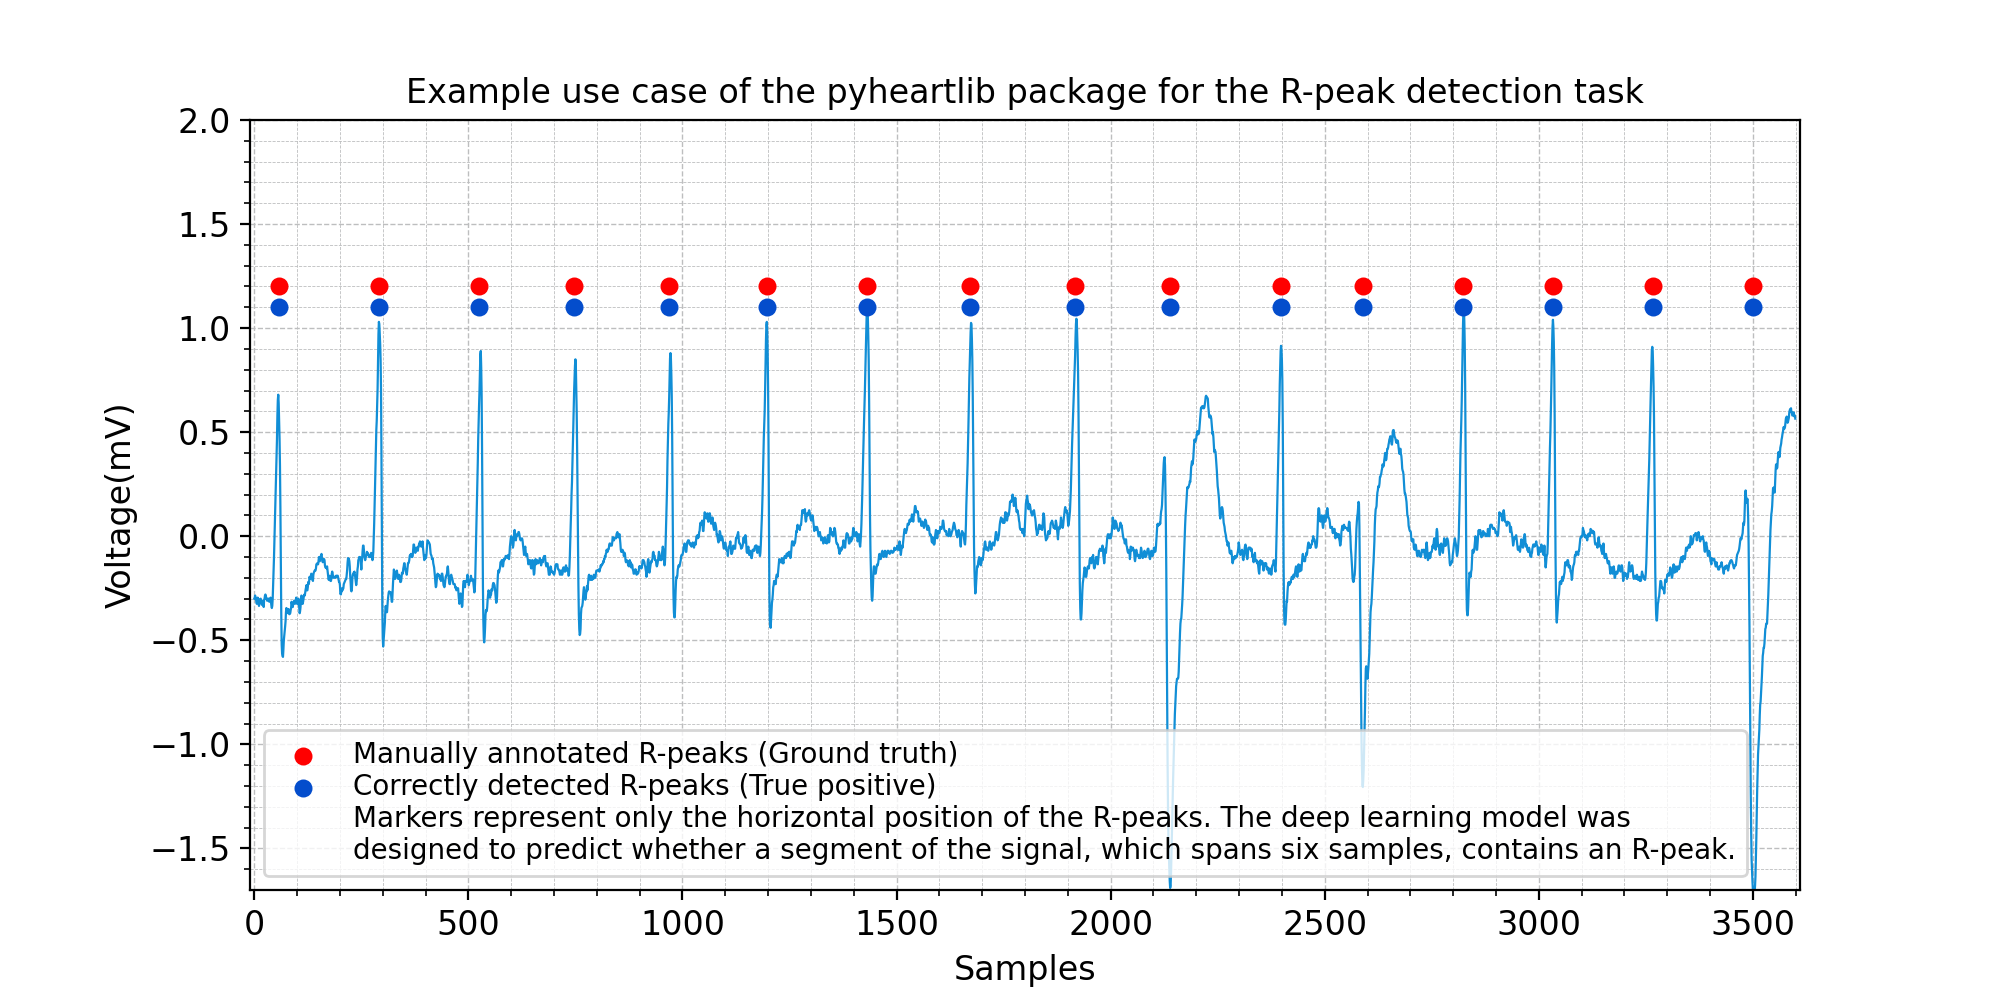

In [34]:
# show results
f = open('result.txt', 'r')
print(f.read())

from IPython.display import Image
Image(filename='plots/3797.png', width=700)